# Read mnist, try basic operations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Reference and inspiration: https://keras.io/examples/mnist_cnn/

In [76]:
class Const:
    """All constants collected together."""
    nrows = 28
    nclasses = 10
    
C = Const()

In [107]:
(xtrain,ytrain), (xtest,ytest) = tf.keras.datasets.mnist.load_data()

def scale_mnist(x):
    x  = x.astype('float32')/255
    x = np.expand_dims(x,3) # Weird extra axis for channels, to make keras work
    return x
    
xtrain = scale_mnist(xtrain)
xtest  = scale_mnist(xtest)

ytrain = tf.keras.utils.to_categorical(ytrain, C.nclasses)
ytest  = tf.keras.utils.to_categorical(ytest, C.nclasses)

In [108]:
print(np.max(xtrain[1,:,:,0]) )
print(xtrain.shape)

1.0
(60000, 28, 28, 1)


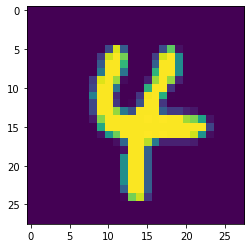

In [110]:
plt.imshow(xtrain[np.random.randint(xtrain.shape[0]),:,:,0]);

In [192]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(C.nrows,C.nrows,1)), # Universal input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(C.nclasses, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=1)

    model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)              


 .393 .146 .112 .095 .084 .071 .070 .064 .062 .057
 .052 .051 .048 .046 .046 .045 .042 .040 .041 .038

Text(0, 0.5, 'Loss')

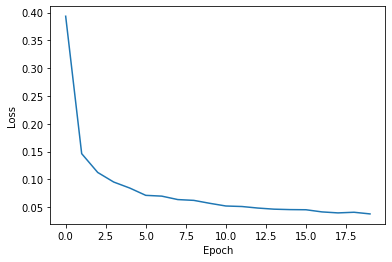

In [193]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print(f" {logs['loss']:.3f}".replace('0.','.'), end='')
        # Funny replace function strips leading zeros (looks better that way)
        

hist = model.fit(xtrain, ytrain,
                  batch_size=128,
                  epochs=20,
                  verbose=0,
                  validation_data=(xtest, ytest),
                  callbacks=[PrintDot()])

plt.plot(hist.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [199]:
score = model.evaluate(xtest, ytest, verbose=0)
print("Test loss:",score[0])
print('Accuracy:', score[1])
print('Percent error:', f'{(1-score[1])*100:0.2f}')

Test loss: 0.02295309518905642
Accuracy: 0.9928
Percent error: 0.72


# Results:

All models are tested on the same split of testing and training data, with 20 epochs. Batch size = 128, Adadelta learning rate = 1.

Because in the long-term I want to pre-train the encoder, but reuse the decoder, it may make sense to keep the convolutional part heavier, and only run one Dense layer at the end. Not sure though. Maybe not. 

* Softmax(784→10). 7,850 params: 0.9274 accuracy
* Conv2d(32,(3,3))→Softmax(21632→10). 216,650 params: 0.9824
* Conv2d(32,(3,3))→Maxpool(2,2)→Softmax(5408→10). 54,410 params: 0.9838
* Conv2d(32,(3,3))→Maxpool(2,2)→Dropout(0.5)→Softmax(5408→10). 54,410 params: 0.9837. No improvement.
* Conv2d(32,(3,3))→Conv2d(64,(3,3))→Maxpool(2,2)→Dropout(0.5)→Softmax(5408→10). 110,986 params: 0.9899
* Conv2d(32,(5,5))→Conv2d(64,(5,5))→Maxpool(2,2)→Dropout(0.5)→Softmax(→10). 116,106 params: 0.9930
* Conv2d(32,(3,3))→Maxpool(2,2)→Conv2d(64,(3,3))→Maxpool(2,2)→Dropout(0.5)→Softmax(1600→10). 34,826 params: 0.9907
* Conv2d(32,(5,5))→Maxpool(2,2)→Conv2d(64,(5,5))→Maxpool(2,2)→Dropout(0.5)→Softmax(1024→10). 62,346 params: 0.9936
* Conv2d(32,(5,5))→Maxpool(2,2)→Conv2d(64,(5,5))→Maxpool(2,2)→Dropout(0.5)→Dense(64)→Dropout(0.5)→Softmax(10). 118,346 params: 0.9939 - that is our favorite for now!
* Conv2d(32,(5,5))→Maxpool(2,2)→Conv2d(64,(5,5))→Maxpool(2,2)→Dropout(0.5)→Dense(128)→Dropout(0.5)→Softmax(10). 184,586 params: 0.9937

Just for info, SOTA for MNIST is about 0.2% error rate: https://paperswithcode.com/sota/image-classification-on-mnist

Text(0, 0.5, 'Error rate')

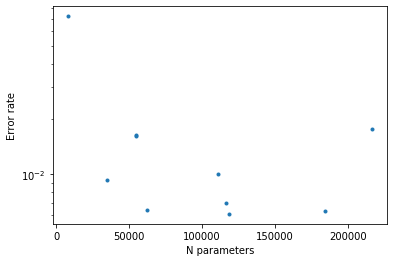

In [191]:
p = [7850, 216650, 54410, 54410, 110986, 116106, 34826, 62346, 118346, 184586]
a = [0.9274, 0.9824, 0.9838, 0.9837, 0.9899, 0.9930, 0.9907, 0.9936, 0.9939, 0.9937]
plt.plot(p,1-np.array(a),'.');
plt.yscale('log')
plt.xlabel('N parameters')
plt.ylabel('Error rate')